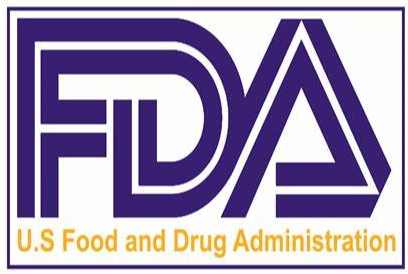

# National Drug Code Hyperlink Prediction by NetAurHPD
This dataset consists of the pharmaceutical classes used to classify drugs in the National Drug Code Directory maintained by the Food and Drug Administration. The original data was downloaded from https://www.fda.gov/Drugs/InformationOnDrugs/ucm142438.htm.

### Data
Each simplex corresponds to an NDC code for a drug, where the nodes are the classes applied to the drug. Note that the same drug substance can have more than one NDC code. For example, different dosages of the same drug may result in multiple NDC codes. The data stpred in two files:

- nverts.txt -> [2, 3, 2, 2, 2,...]

- simplices.txt -> [4, 1, 117, 129, 1, 51, 1,...]

**Meaning**:

Hyperlink 1 = {4,1}

Hyperlink 2 = {117,129,1}

Hyperlink 3 = {51,1}

In [1]:
import sys
import os

In [2]:
sys.path.append(os.path.abspath("../..")) 

In [3]:
from NetAurHPD.NetAurHPD_M5 import NetAurHPD_M5
from Examples.data_preprocess import data_preprocess, create_train_and_test_sets
from NetAurHPD.network_auralization import SignalPropagation
from Examples.utils import negative_sampling, save_hyperlinks_with_label
from NetAurHPD.result_optimization_and_analysis import optimize_results_and_calc_metrics

Data files path

In [4]:
nodes_data_dir = "ndc_data/NDC-classes-simplices.txt"
groups_size_data_dir = "ndc_data/NDC-classes-nverts.txt"

Load data and transform into hypergraph

In [5]:
unique_hyperlink_dict, nodes = data_preprocess(nodes_data_dir, groups_size_data_dir)

Number of hyperlinks: 46283


Save positive hyperlinks with positive label

In [6]:
positive_hyperlink_dict = save_hyperlinks_with_label(unique_hyperlink_dict)

Negative sampling - create negative hyperlinks examples

In [7]:
negative_hyperlink_dict = negative_sampling(nodes,unique_hyperlink_dict)

Create train and test sets

In [8]:
train_positive_hyperlink_dict, train_hyperlink_dict, y_train, test_hyperlink_dict, y_test = create_train_and_test_sets(positive_hyperlink_dict, negative_hyperlink_dict)

Train positive hyperlinks: 628
Train negative hyperlinks: 628
Test positive hyperlinks: 419
Test negative hyperlinks: 419


Create SignalPropagation Object

In [9]:
instrument = SignalPropagation(momentum=0.999, response_len=10000, tqdm=lambda x: x, device='cpu')

1. Run network auralization over the train set nodes
2. Create the hyperlinks waveforms representation

Nodes: 1149
Edges: 4843
HyperLinks: 628


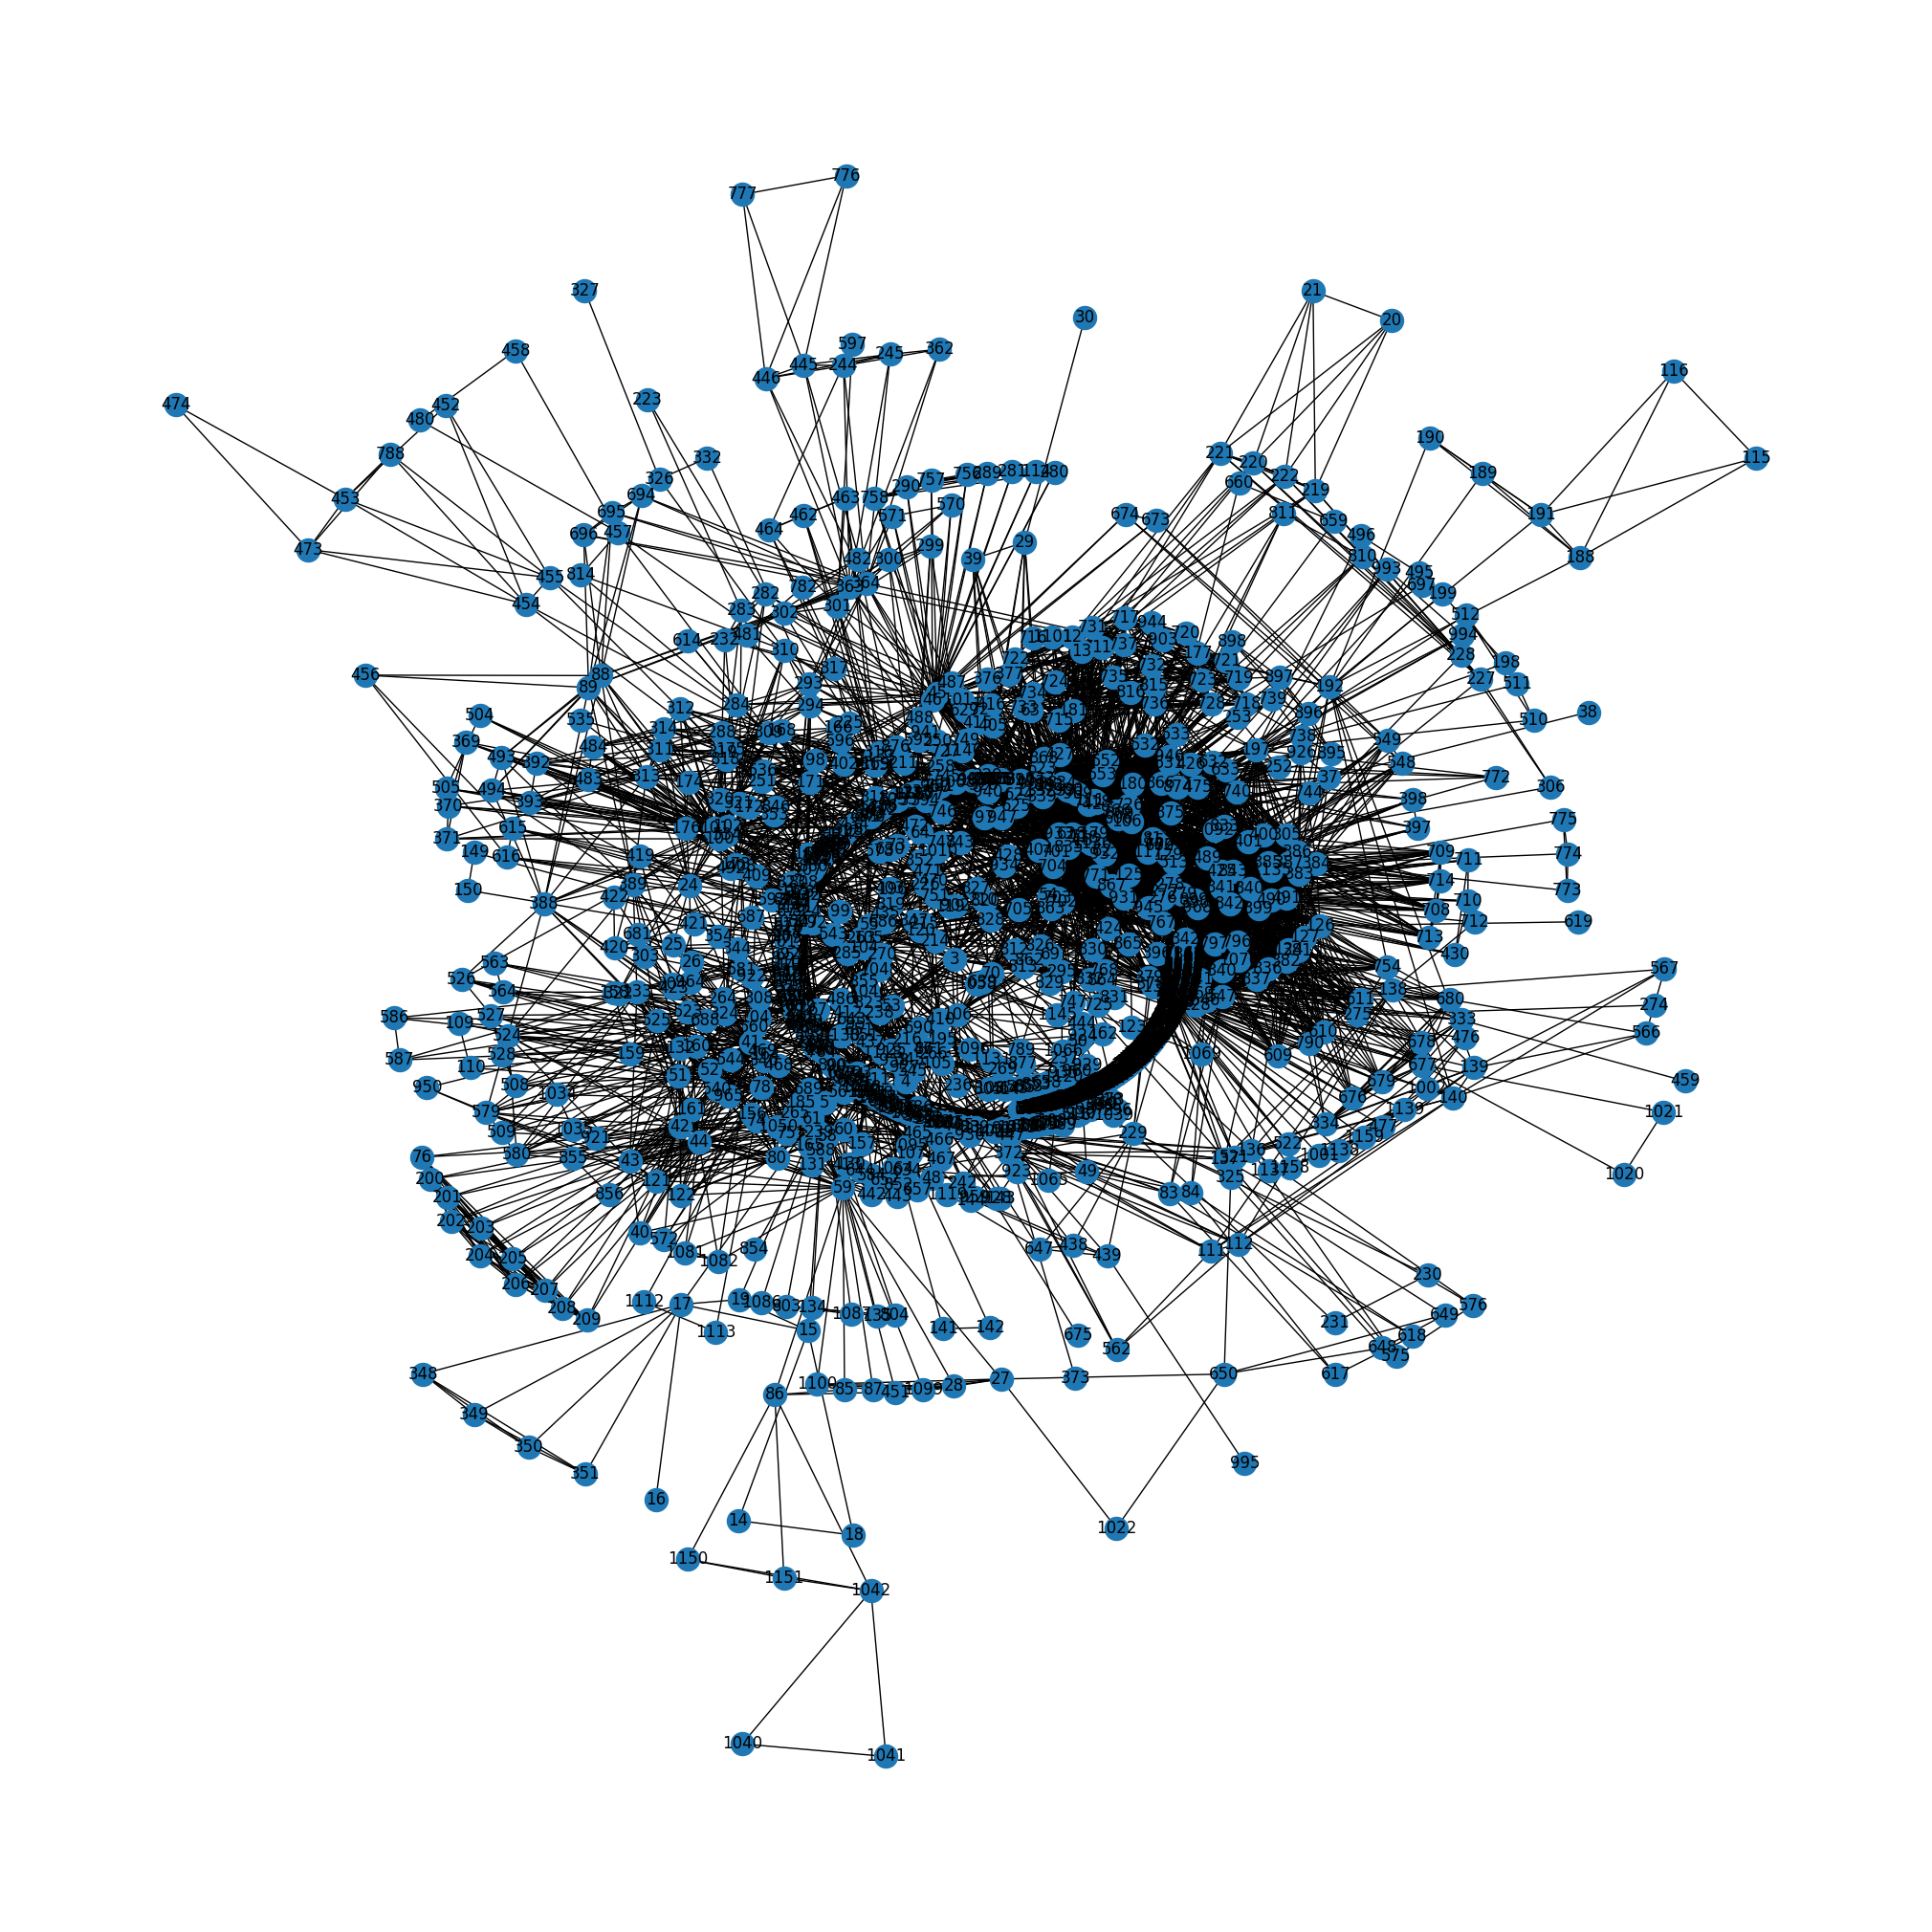

In [10]:
train_hyperlinks_waveforms, test_hyperlinks_waveforms = instrument.networkx_auralization(train_positive_hyperlink_dict,train_hyperlink_dict,test_hyperlink_dict,nodes,True)

Create M5 network

In [11]:
NetAurHPD_DL_architecture = NetAurHPD_M5(n_input=1, n_output=1)

Train M5 over the data and present the results

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]C:\Users\Bar-Tov\Documents\Tamir\Studies\second grade\Thesis\CHESHIRE\cheshire-gapfilling\chesenv\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1256])


  2%|██                                                                                 | 1/40 [00:18<12:06, 18.63s/it]

torch.Size([1256])


  5%|████▏                                                                              | 2/40 [00:28<08:42, 13.74s/it]

torch.Size([1256])


  8%|██████▏                                                                            | 3/40 [00:34<06:10, 10.02s/it]

torch.Size([1256])


 10%|████████▎                                                                          | 4/40 [00:39<04:51,  8.09s/it]

torch.Size([1256])


 12%|██████████▍                                                                        | 5/40 [00:44<04:05,  7.02s/it]

torch.Size([1256])


 15%|████████████▍                                                                      | 6/40 [00:50<03:39,  6.46s/it]

torch.Size([1256])


 18%|██████████████▌                                                                    | 7/40 [00:55<03:19,  6.06s/it]

torch.Size([1256])


 20%|████████████████▌                                                                  | 8/40 [01:00<03:04,  5.77s/it]

torch.Size([1256])


 22%|██████████████████▋                                                                | 9/40 [01:07<03:06,  6.00s/it]

torch.Size([1256])


 25%|████████████████████▌                                                             | 10/40 [01:13<03:06,  6.23s/it]

torch.Size([1256])


 28%|██████████████████████▌                                                           | 11/40 [01:20<03:01,  6.27s/it]

torch.Size([1256])


 30%|████████████████████████▌                                                         | 12/40 [01:25<02:48,  6.01s/it]

torch.Size([1256])


 32%|██████████████████████████▋                                                       | 13/40 [01:30<02:36,  5.80s/it]

torch.Size([1256])


 35%|████████████████████████████▋                                                     | 14/40 [01:36<02:26,  5.64s/it]

torch.Size([1256])


 38%|██████████████████████████████▊                                                   | 15/40 [01:42<02:22,  5.72s/it]

torch.Size([1256])


 40%|████████████████████████████████▊                                                 | 16/40 [01:47<02:14,  5.60s/it]

torch.Size([1256])


 42%|██████████████████████████████████▊                                               | 17/40 [01:52<02:05,  5.46s/it]

torch.Size([1256])


 45%|████████████████████████████████████▉                                             | 18/40 [01:57<01:57,  5.36s/it]

torch.Size([1256])


 48%|██████████████████████████████████████▉                                           | 19/40 [02:03<01:57,  5.60s/it]

torch.Size([1256])


 50%|█████████████████████████████████████████                                         | 20/40 [02:09<01:50,  5.54s/it]

torch.Size([1256])


 52%|███████████████████████████████████████████                                       | 21/40 [02:14<01:43,  5.44s/it]

torch.Size([1256])


 55%|█████████████████████████████████████████████                                     | 22/40 [02:19<01:36,  5.35s/it]

torch.Size([1256])


 57%|███████████████████████████████████████████████▏                                  | 23/40 [02:24<01:30,  5.31s/it]

torch.Size([1256])


 60%|█████████████████████████████████████████████████▏                                | 24/40 [02:29<01:24,  5.28s/it]

torch.Size([1256])


 62%|███████████████████████████████████████████████████▎                              | 25/40 [02:35<01:18,  5.25s/it]

torch.Size([1256])


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [02:40<01:13,  5.23s/it]

torch.Size([1256])


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [02:45<01:07,  5.22s/it]

torch.Size([1256])


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [02:50<01:02,  5.20s/it]

torch.Size([1256])


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [02:55<00:57,  5.23s/it]

torch.Size([1256])


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [03:01<00:53,  5.37s/it]

torch.Size([1256])


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [03:07<00:49,  5.51s/it]

torch.Size([1256])


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [03:12<00:43,  5.47s/it]

torch.Size([1256])


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [03:18<00:38,  5.44s/it]

torch.Size([1256])


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [03:23<00:32,  5.40s/it]

torch.Size([1256])


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [03:28<00:26,  5.35s/it]

torch.Size([1256])


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [03:34<00:21,  5.35s/it]

torch.Size([1256])


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [03:39<00:16,  5.35s/it]

torch.Size([1256])


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [03:45<00:10,  5.40s/it]

torch.Size([1256])


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [03:50<00:05,  5.39s/it]

torch.Size([1256])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [03:55<00:00,  5.89s/it]


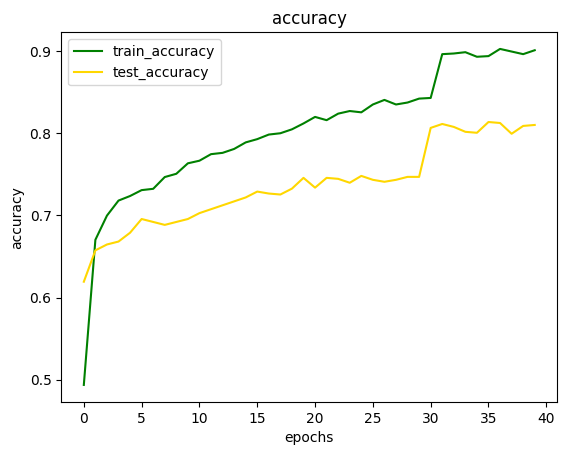

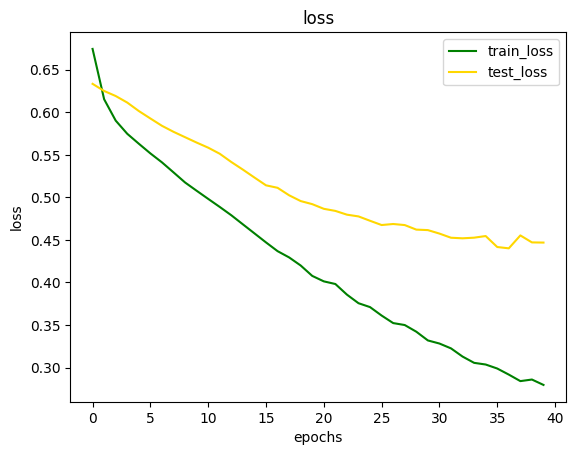

Max train accuracy: 0.9028662420382165
Max test accuracy: 0.8138424821002387


<Figure size 640x480 with 0 Axes>

In [12]:
y_pred = NetAurHPD_DL_architecture.predict(train_hyperlinks_waveforms, y_train, test_hyperlinks_waveforms, y_test)

Calculate optimal threshold by Youden's J Statistic and present performance metrics

In [13]:
optimize_results_and_calc_metrics(y_test, y_pred)

Model Results:
optimal threshold:  0.528
AUC:  0.868
Accuracy:  0.813
Recall:  0.785
Precision:  0.831
F1:  0.807
FPR:  0.16
